In [1]:
import nltk
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

/home/laxmansinghtomar/assignments/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('brown')
nltk.download('stopwords')
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package brown to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/laxmansinghtomar/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [4]:
import torch
import re

def calculate_flesch_reading_ease(text):
    # Remove punctuation from the text
    text = re.sub(r'[^\w\s]', '', text)

    # Split the text into sentences and words
    sentences = re.split(r'[.!?]', text)
    words = re.findall(r'\w+', text)

    # Calculate the average number of words per sentence
    average_words_per_sentence = len(words) / len(sentences)

    # Calculate the average number of syllables per word
    total_syllables = 0
    for word in words:
        total_syllables += count_syllables(word)
    average_syllables_per_word = total_syllables / len(words)

    # Calculate the Flesch Reading Ease score
    fre_score = 206.835 - (1.015 * average_words_per_sentence) - (84.6 * average_syllables_per_word)

    return fre_score

import pyphen

dic = pyphen.Pyphen(lang='en')

def count_syllables(word):
    hyphenated_word = dic.inserted(word)
    syllables = hyphenated_word.split('-')
    return len(syllables)

In [5]:
from transformers import pipeline

# Create a zero-shot classification pipeline using the BART-large-mnli model
zero_shot_pipeline = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [45]:
import re
from collections import Counter
from nltk.corpus import stopwords

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def sentiment_alignment(text, summary):
    text = preprocess_text(text)
    summary = preprocess_text(summary)
        
    # Define the class names
    class_names = ["positive", "negative", "mixed"]
    
    # Get sentiment scores using the BART-large-mnli model
    text_sentiment = zero_shot_pipeline(text, class_names)
    text_output = text_sentiment['labels'][text_sentiment['scores'].index(max(text_sentiment['scores']))]
    
    summary_sentiment = zero_shot_pipeline(summary, class_names)
    summary_output = summary_sentiment['labels'][summary_sentiment['scores'].index(max(summary_sentiment['scores']))]
    
    if text_output == summary_output:
        return 1
    else:
        return 0


def detect_repetitive_phrases(input_string):
    stopwords_set = set(stopwords.words('english'))
    input_string = input_string.lower()
    words = re.findall(r'\b\w+\b', input_string)
    words = [word for word in words if word not in stopwords_set]
    phrases = [' '.join(t) for t in zip(words[:-2], words[1:-1], words[2:])]
    phrase_counts = Counter(phrases)
    repetitive_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}

    if repetitive_phrases:    # if dictionary is not empty
        return 1    # text contains repetitive phrases
    else:
        return 0    # no repetitive phrases found


def keyword_overlap(text_a, text_b):
    # Preprocess the text
    text_a = preprocess_text(text_a)
    text_b = preprocess_text(text_b)
    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text_a, text_b])
    overlap_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return overlap_score
    

def sentence_similarity(sent_a, sent_b):
    # Tokenize the input sentences
    inputs = tokenizer([sent_a, sent_b], return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Get the embeddings from the MiniLM model
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    # Calculate the similarity score
    similarity_score = torch.nn.functional.cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0)).item()
    return similarity_score


def keyword_overlap(text_a, text_b):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text_a, text_b])
    overlap_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    return overlap_score


def readability(text):
    preproc_text = preprocess_text(text)
    return calculate_flesch_reading_ease(preproc_text)


def count_noun_phrases(text):
    text = preprocess_text(text)
    blob = TextBlob(text)
    return blob.noun_phrases


def feature_highlighting(text, summary):
    text = preprocess_text(text)
    summary = preprocess_text(summary)
    
    text_features = set(count_noun_phrases(text))
    summary_features = set(count_noun_phrases(summary))
    
    if not text_features and not summary_features:
        return 0
    
    feature_coverage_score = len(text_features.intersection(summary_features)) / len(text_features)
    return feature_coverage_score


def extract_last_message(conversation):
    # Split the conversation string into individual messages
    messages = re.split(r'\nUser:', conversation)
    
    # Remove any leading or trailing whitespace from each message
    messages = [msg.strip() for msg in messages]
    
    # Identify the last message in the list of messages
    last_message = messages[-1]
    
    return last_message


def last_message_coverage(conversation, last_message, summary):
    return sentence_similarity(last_message, summary)


def context_inclusion(conversation, last_message, summary):
    conv_similarity = sentence_similarity(conversation, summary)
    last_msg_similarity = sentence_similarity(last_message, summary)
    return conv_similarity / last_msg_similarity


def pii_detection(summary, pii_list=[]):
    # Check for Twitter handles
    twitter_handle_pattern = r'@\w+'
    twitter_handles = re.findall(twitter_handle_pattern, summary)
    
    # Combine the PII list with the detected Twitter handles
    combined_pii_list = pii_list + twitter_handles
    
    # Check if any PII elements are present in the summary
    pii_present = any(pii in summary for pii in combined_pii_list)
    
    # Return 1 if no PII elements are present, 0 otherwise
    return 1 if not pii_present else 0


def product_name_presence(product_name, text, summary):
    if summary.lower() == "none":
        return 1
    in_text = product_name.lower() in text.lower()
    in_summary = product_name.lower() in summary.lower()
    return int(in_text == in_summary)

In [7]:
def evaluate_review_summary(product_name, text, summary):
    # Metrics for RecordTypeReview
    summary = preprocess_text(summary)
    
    coverage_score = keyword_overlap(text, summary)
    
    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.4
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0
    
    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0  # Set a lower limit of 0 for clarity_score
    clarity_score = raw_clarity_score / 206.835
    sentiment_align_score = sentiment_alignment(text, summary)
    feature_highlight_score = feature_highlighting(text, summary)
    
    # Weights for RecordTypeReview
    weights = {
        "coverage": 0.25,
        "conciseness": 0.1,
        "clarity": 0.05,
        "sentiment_alignment": 0.2,
        "feature_highlighting": 0.2,
    }
    
    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + sentiment_align_score * weights["sentiment_alignment"]
        + feature_highlight_score * weights["feature_highlighting"]
    )
    return {
        "coverage_score": coverage_score,
        #"clarity_score": clarity_score,
        "conciseness_score": conciseness_score
        "sentiment_align_score": sentiment_align_score,
        "feature_highlight_score":feature_highlight_score,
        "overall_score": overall_score
    }

def evaluate_forum_conversation_summary(text, last_message, summary, pii_list=[]):
    # Metrics for RecordTypeForumConversation
    summary = preprocess_text(summary)
    
    coverage_score = keyword_overlap(text, summary)
    
    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.4
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0 
    
    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0
    clarity_score = raw_clarity_score / 206.835
    last_msg_coverage_score = last_message_coverage(text, last_message, summary)
    context_inclusion_score = context_inclusion(text, last_message, summary)
    pii_removal_score = pii_removal(summary, pii_list)

    # Weights for RecordTypeForumConversation
    weights = {
        "coverage": 0.25,
        "conciseness": 0.1,
        "clarity": 0.05,
        "last_message_coverage": 0.5,
        "context_inclusion": 0.2,
        "pii_removal": 1.0,
    }

    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + last_msg_coverage_score * weights["last_message_coverage"]
        + context_inclusion_score * weights["context_inclusion"]
        + pii_removal_score * weights["pii_removal"]
    )
    return {
        "coverage_score": coverage_score,
        #"clarity_score": clarity_score,
        "conciseness_score": conciseness_score,
        "last_message_coverage_score": last_msg_coverage_score,
        "context_inclusion_score":context_inclusion_score,
        "pii_removal_score": pii_removal_score,
        "overall_score": overall_score
    }

def evaluate_survey_summary(product_name, text, summary):
    # Metrics for RecordTypeSurvey
    summary = preprocess_text(summary)
    
    coverage_score = keyword_overlap(text, summary)

    text_sentences = len(preprocess_text(text).split('.'))
    summary_sentences = len(summary.split('.'))
    summary_to_text_ratio = summary_sentences / text_sentences
    conciseness_threshold = 0.4
    conciseness_score = 1 if summary_to_text_ratio <= conciseness_threshold else 0     
    
    raw_clarity_score = max(0, calculate_flesch_reading_ease(summary)) if summary.lower() != "none" else 0
    clarity_score = raw_clarity_score / 206.835
    sentiment_align_score = sentiment_alignment(text, summary)
    feature_highlight_score = feature_highlighting(text, summary)

    # Weights for RecordTypeSurvey
    weights = {
        "coverage": 0.25,
        "conciseness": 0.1,
        "clarity": 0.05,
        "sentiment_alignment": 0.2,
        "feature_highlighting": 0.2,
    }

    # Calculate the final evaluation score
    overall_score = (
        coverage_score * weights["coverage"]
        + conciseness_score * weights["conciseness"]
        #+ clarity_score * weights["clarity"]
        + sentiment_align_score * weights["sentiment_alignment"]
        + feature_highlight_score * weights["feature_highlighting"]
    )
    return {
        "coverage_score": coverage_score,
        #"clarity_score": clarity_score,
        'conciseness_score':conciseness_score,
        "sentiment_align_score": sentiment_align_score,
        "feature_highlight_score":feature_highlight_score,
        "overall_score": overall_score
    }

In [8]:
def evaluate_summary(record_type, text, summary, product_name=None, pii_list=[]):
    if record_type == "Appstore/Playstore":
        return evaluate_review_summary(product_name, text, summary)
    elif record_type == "Twitter":
        last_message = extract_last_message(text)
        return evaluate_forum_conversation_summary(text, last_message, summary, pii_list)
    elif record_type == "G2":
        return evaluate_survey_summary(product_name, text, summary)
    else:
        raise ValueError(f"Unknown record type: {record_type}")

In [9]:
import pandas as pd


df = pd.read_csv("Enterpret Summary Generation Assignment - final_public_train.csv")
df.head(2)

,Customer,Type,Text,Summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."


In [10]:
print(df.query("Type=='Twitter'")['Text'].iloc[500])

User: .what is your best productivity tool as an SME/ startup entrepreneur? For me, it's Notion/ Airtable for now. #SageForSmallBiz #SageForStartups
User: @MorolongZA I love Notion but Airtable is one of my favourite tools ever. I used to spend so much time on ProductHunt. I think it’s time to discover some new stuff.
User: @rumbimak .my sister please, wena you're a shareholder in Notion. I need to play around with an AI tool that generates presentation designs or formats so I can just edit. I waste so much time worrying about designs. Canva doesn't help no more
User: @MorolongZA Firstly, @NotionHQ may as well give me shares at this point. Secondly, check out @MeetGamma. I haven’t used it yet but I’ve also been looking for the same solution.


In [11]:
print(df.query("Type=='G2'")['Text'].iloc[230])

User: Helping with our discovery process for opportunity solutions trees, for roadmap and timelines, for anything really
User: I love that there's "infinite space" , if you prep a presentation on ppt for example, you're limited to slides but with Miro the sky is the limit
User: We have a business account and sometimes colleagues from other departments are part of a different account and we can't give them editing rights to the boards


In [12]:
df.columns = ['customer', 'type', 'text', 'summary']

In [13]:
df.head(2)

,customer,type,text,summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."


In [14]:
print(df.shape)

df = df.dropna()
print(f"Data after dropping null values: {df.shape}")

df = df.drop_duplicates(keep='first')

print(f"Data after dropping duplicate rows: {df.shape}")

(5009, 4)
Data after dropping null values: (4001, 4)
Data after dropping duplicate rows: (4001, 4)


In [15]:
def is_empty_string(value):
    return value.strip() == ""

empty_string_check = df[['text', 'summary']].applymap(is_empty_string)
df = df[~empty_string_check.any(axis=1)]
print(f"Data after dropping rows w/ empty strings: {df.shape}")

Data after dropping rows w/ empty strings: (3982, 4)


In [16]:
appstore_df = df[df['type'] == 'Appstore/Playstore']
twitter_df = df[df['type'] == 'Twitter']
g2_df = df[df['type'] == 'G2']

In [17]:
print(g2_df.shape)
print(twitter_df.shape)
print(appstore_df.shape)

(398, 4)
(2639, 4)
(945, 4)


In [18]:
import pandas as pd
from tqdm import tqdm

# Register the progress_apply function with pandas
tqdm.pandas()

g2_df_features = g2_df.progress_apply(
    lambda row: evaluate_summary(
        row['type'],
        row['text'],
        row['summary'],
        product_name=row.get('customer'),
    ),
    axis=1
)

100%|██████████| 398/398 [22:21<00:00,  3.37s/it]


In [19]:
g2_df.reset_index(drop=True, inplace=True)
g2_df['row_number'] = g2_df.index

g2_df_features_df = pd.DataFrame(g2_df_features.tolist())
g2_df_features_df.reset_index(drop=True, inplace=True)
g2_df_features_df['row_number'] = g2_df_features_df.index

merged_g2_df = pd.merge(g2_df, g2_df_features_df, on='row_number', how='inner')

merged_g2_df.drop(columns=['row_number'], inplace=True)

/tmp/ipykernel_169748/1436586940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2_df['row_number'] = g2_df.index


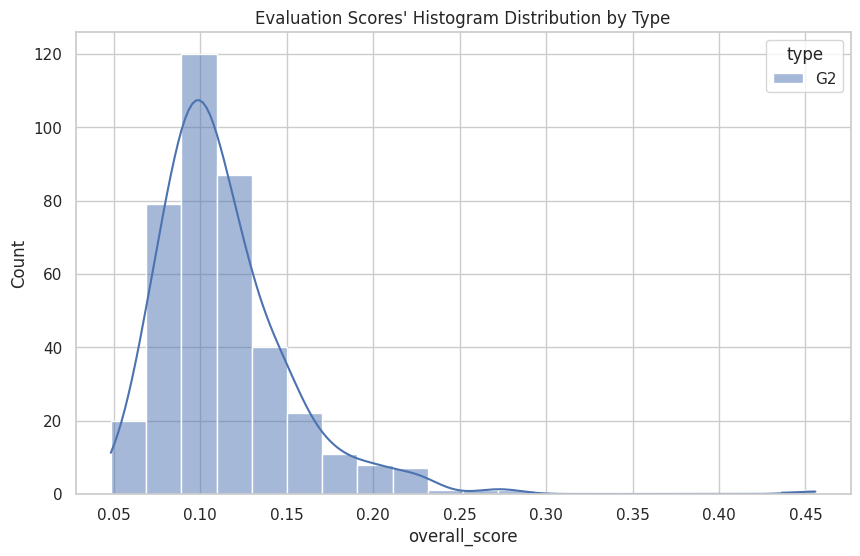

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_g2_df, x="overall_score", hue="type", kde=True, bins=20)
plt.title("Evaluation Scores' Histogram Distribution by Type")
plt.show()


In [44]:
merged_g2_df.sort_values(by="clarity_score", ascending=True).head()

,customer,type,text,summary,coverage_score,clarity_score,sentiment_align_score,feature_highlight_score,overall_score
397,figma,G2,User: Web meetings with employees in offices f...,The product is helping the User to organize th...,0.356700,0.0,0,0.0,0.163993
264,figma,G2,User: FigJam allows me and my team to quickly ...,Users appreciate Figma for enabling remote ide...,0.208182,0.0,0,0.0,0.094521
269,figma,G2,User: Being able to run ideation sessions with...,"Users appreciate Figjam for its ease of use, t...",0.232098,0.0,0,0.0,0.129105
272,figma,G2,User: Keeping large collections readible and d...,The user appreciates FigJam for its ease in cr...,0.258288,0.0,0,0.0,0.143870
79,figma,G2,User: How might we collaborate efficiently in ...,Users appreciate Miro's ability to align remot...,0.220212,0.0,0,0.0,0.092730


In [40]:
merged_g2_df.sort_values(by="coverage_score", ascending=True).tail().values

array([['figma', 'G2',
        'User: I have created a Creative Hack workshop template which I use to help teams and clients come up with ideas. \nI\'ll also use Miro for other team tasks in which multiple people need to make inputs. \nIts helpful for capturing a large amount of information in a little amount time, and ultimately making sense of those inputs.\nUser: I describe Miro as an Adobe Illustrator Group Chat. I love the drag and drop flexibility of it and ease of use, which allows me to capture ideas and feedback in real time. Even when I\'m working with large groups of people, the tool enables me to synthesize conversations and sharebacks in a way that captures the essence of a meeting.\nUser: I have a few small feedback options for Miro. \n \n1. For some reason I am forced to put a password on a board when I make it publically editable. It didn\'t used to be like this and I find it annoying that I have to do that every time. I end up just saying "miroboard" for everything. \n

In [30]:
zsp = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", return_all_scores=False)

text = "User: lack of freeform tools on the market with lots of customization, which is why I prefer Miro to its competitors that I've tried\nUser: the flexibility to collaborate with others, and mainly the freeform design\nUser: text box limits, lack of automatic spell correction, constant new feature/update pop-ups"
summary = 'The user appreciates the flexibility, accessibility, and ease of use of the Miro board, which allows for collaborative input, effort, and process management. They also appreciate the ability to track changes and revert changes through the history. The user also mentions that the large Miro board may take time to load, and some setup may be unlocked, causing unintentional movement. The user also mentions that the page upload is blurry and slow.'


text = preprocess_text(text)
summary = preprocess_text(summary)
        
# Define the class names
class_names = ["positive", "negative", "mixed"]
    
    # Get sentiment scores using the BART-large-mnli model
text_sentiment = zsp(text, class_names)
summary_sentiment = zsp(summary, class_names)

print(text_sentiment)
print(summary_sentiment)

{'sequence': 'user lack of freeform tools on the market with lots of customization which is why i prefer miro to its competitors that ive tried user the flexibility to collaborate with others and mainly the freeform design user text box limits lack of automatic spell correction constant new featureupdate popups', 'labels': ['mixed', 'positive', 'negative'], 'scores': [0.5406626462936401, 0.2918400764465332, 0.16749729216098785]}
{'sequence': 'the user appreciates the flexibility accessibility and ease of use of the miro board which allows for collaborative input effort and process management they also appreciate the ability to track changes and revert changes through the history the user also mentions that the large miro board may take time to load and some setup may be unlocked causing unintentional movement the user also mentions that the page upload is blurry and slow', 'labels': ['mixed', 'positive', 'negative'], 'scores': [0.6433013081550598, 0.3534436821937561, 0.0032550070900470

In [33]:
text_sentiment['labels'][text_sentiment['scores'].index(max(text_sentiment['scores']))]

'mixed'

In [46]:
sentiment_alignment(text, summary)

1

In [ ]:
# Apply the evaluate_summary function with a progress bar
appstore_df_features = appstore_df.progress_apply(
    lambda row: evaluate_summary(
        row['type'],
        row['text'],
        row['summary'],
        product_name=row.get('customer'),
    ),
    axis=1
)
appstore_df = appstore_df.merge(pd.DataFrame(appstore_df_features.tolist()))

100%|██████████| 945/945 [01:33<00:00, 10.12it/s]


In [29]:
# Sample texts
row = df[df['type']=='Twitter'].sort_values(by="evaluation_score", ascending=True).iloc[-1]
product_name = row['customer']
text = row['text']
summary = row['summary']

# Calculate individual components
coverage_score = keyword_overlap(text, summary)
conciseness_score = len(summary) / len(text)
clarity_score = max(0, calculate_flesch_reading_ease(summary))
sentiment_align_score = sentiment_alignment(text, summary)
feature_highlight_score = feature_highlighting(text, summary)
product_name_score = product_name_presence(product_name, text, summary)

# Print the results
print("Coverage Score:", coverage_score)
print("Conciseness Score:", conciseness_score)
print("Clarity Score:", clarity_score)
print("Sentiment Alignment Score:", sentiment_align_score)
print("Feature Highlighting Score:", feature_highlight_score)
print("Product Name Score:", product_name_score)

Coverage Score: 0.0
Conciseness Score: 0.11643835616438356
Clarity Score: 119.19000000000003
Sentiment Alignment Score: 0.75
Feature Highlighting Score: 0.0
Product Name Score: 1
